In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

In [2]:
df_small_noise = pd.read_csv('NAB/data/artificialNoAnomaly/art_daily_small_noise.csv')
df_daily_jumpsup = pd.read_csv('NAB/data/artificialWithAnomaly/art_daily_jumpsup.csv')

In [3]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


In [8]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

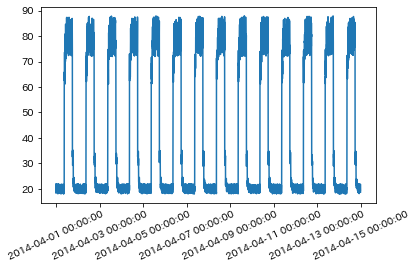

In [9]:
plot_dates_values(df_small_noise)

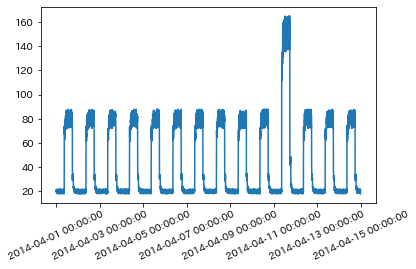

In [10]:
plot_dates_values(df_daily_jumpsup)

In [12]:
def get_value_from_df(df):
    return df.value.to_list()

def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


training_value = get_value_from_df(df_small_noise)

training_value, training_mean, training_std = normalize(training_value)
len(training_value)

4032

In [13]:
TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
        
    return np.expand_dims(output, axis=2)

x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


In [16]:
model = keras.Sequential()
model.add(layers.Input(shape=(x_train.shape[1], x_train.shape[2])))

model.add(layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"))

model.add(layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 288, 1)           

In [17]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")]
)

Epoch 1/50
27/27 [==============================] - 3s 94ms/step - loss: 0.4421 - val_loss: 0.0605
Epoch 2/50
27/27 [==============================] - 2s 80ms/step - loss: 0.0780 - val_loss: 0.0483
Epoch 3/50
27/27 [==============================] - 2s 80ms/step - loss: 0.0598 - val_loss: 0.0388
Epoch 4/50
27/27 [==============================] - 2s 80ms/step - loss: 0.0504 - val_loss: 0.0322
Epoch 5/50
27/27 [==============================] - 2s 83ms/step - loss: 0.0424 - val_loss: 0.0287
Epoch 6/50
27/27 [==============================] - 2s 80ms/step - loss: 0.0368 - val_loss: 0.0264
Epoch 7/50
27/27 [==============================] - 2s 80ms/step - loss: 0.0329 - val_loss: 0.0244
Epoch 8/50
27/27 [==============================] - 2s 80ms/step - loss: 0.0300 - val_loss: 0.0233
Epoch 9/50
27/27 [==============================] - 2s 80ms/step - loss: 0.0279 - val_loss: 0.0229
Epoch 10/50
27/27 [==============================] - 2s 82ms/step - loss: 0.0261 - val_loss: 0.0227
Epoch 11/

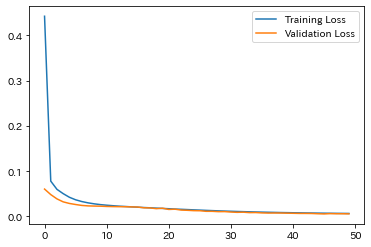

In [18]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

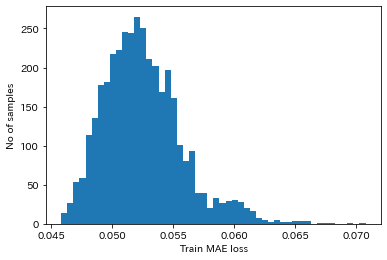

Reconstruction error threshold:  0.07078780435421456


In [19]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

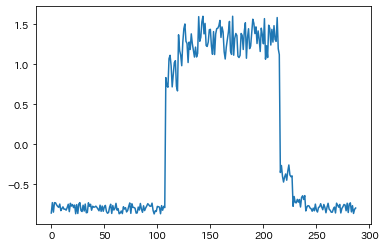

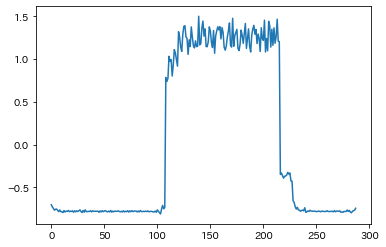

In [20]:
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

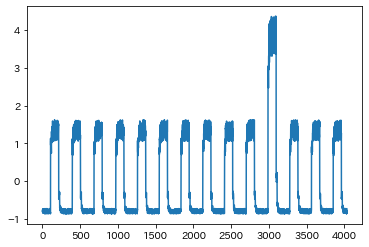

Test input shape:  (3744, 288, 1)


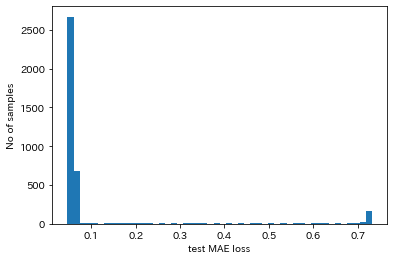

Number of anomaly samples:  402
Indices of anomary samples;  (array([ 793,  794, 2522, 2699, 2701, 2702, 2703, 2704, 2705, 2706, 2707,
       2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718,
       2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729,
       2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751,
       2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762,
       2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773,
       2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784,
       2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795,
       2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806,
       2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817,
       2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828,
       2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2

In [24]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value)
plt.show()


x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomary samples; ", np.where(anomalies))

In [25]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

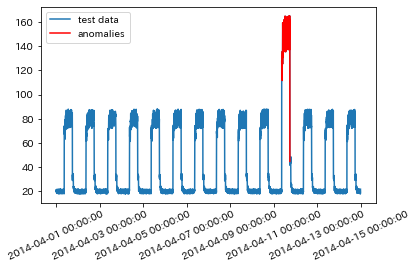

In [29]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_daily_jumpsup["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_daily_jumpsup["value"].to_list()
plt.plot(dates, values, label="test data")


dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()